In [2]:
pip install torch torchvision opencv-python


Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import os


In [5]:
for class_folder, label in classes.items():
    class_path = os.path.join(root_dir, class_folder)
    if not os.path.exists(class_path):
        print(f"Warning: Directory not found: {class_path}")
        continue

    print(f"\nClass: {class_folder} (Label: {label})")
    for video_folder in os.listdir(class_path):
        video_path = os.path.join(class_path, video_folder)
        if not os.path.isdir(video_path):
            continue
        
        print(f"  Video Folder: {video_folder}")  # Print video folder names
        
        # Collect all frames within the video folder
        for frame_file in os.listdir(video_path):
            if frame_file.endswith(".jpg"):
                frame_paths.append(os.path.join(video_path, frame_file))
                labels.append(label)



Class: frames_abuse (Label: 0)
  Video Folder: Abuse001_x264
  Video Folder: Abuse002_x264
  Video Folder: Abuse003_x264
  Video Folder: Abuse004_x264
  Video Folder: Abuse005_x264
  Video Folder: Abuse006_x264
  Video Folder: Abuse007_x264
  Video Folder: Abuse008_x264
  Video Folder: Abuse009_x264
  Video Folder: Abuse010_x264

Class: frames_arrest (Label: 1)
  Video Folder: Arrest001_x264
  Video Folder: Arrest002_x264
  Video Folder: Arrest003_x264
  Video Folder: Arrest004_x264
  Video Folder: Arrest005_x264
  Video Folder: Arrest006_x264
  Video Folder: Arrest007_x264
  Video Folder: Arrest008_x264
  Video Folder: Arrest009_x264
  Video Folder: Arrest010_x264

Class: frames_normal (Label: 2)
  Video Folder: Normal_Videos_003_x264
  Video Folder: Normal_Videos_006_x264
  Video Folder: Normal_Videos_010_x264
  Video Folder: Normal_Videos_014_x264
  Video Folder: Normal_Videos_015_x264
  Video Folder: Normal_Videos_018_x264
  Video Folder: Normal_Videos_019_x264
  Video Folder: Nor

In [4]:
import os
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Step 1: Define the Dataset Class
class VideoFrameDataset(Dataset):
    def __init__(self, frame_paths, labels, transform=None):
        self.frame_paths = frame_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.frame_paths)

    def __getitem__(self, idx):
        # Load image
        frame_path = self.frame_paths[idx]
        image = Image.open(frame_path).convert("RGB")
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        
        # Load label
        label = self.labels[idx]
        return image, label

# Step 2: Gather all frame paths and labels
root_dir = "C:\\Users\\Rohini\\capstone_Project\\prjct2\\frames"  # Replace with your base folder
classes = {"frames_abuse": 0, "frames_arrest": 1, "frames_normal": 2}
frame_paths = []
labels = []

for class_folder, label in classes.items():
    class_path = os.path.join(root_dir, class_folder)
    if not os.path.exists(class_path):
        print(f"Warning: Directory not found: {class_path}")
        continue

    for video_folder in os.listdir(class_path):
        video_path = os.path.join(class_path, video_folder)
        if not os.path.isdir(video_path):
            continue
        
        # Collect all frames within the video folder
        for frame_file in os.listdir(video_path):
            if frame_file.endswith(".jpg"):
                frame_paths.append(os.path.join(video_path, frame_file))
                labels.append(label)

# Step 3: Split data into training, validation, and testing
frame_train, frame_test, label_train, label_test = train_test_split(
    frame_paths, labels, test_size=0.2, random_state=42
)

frame_train, frame_val, label_train, label_val = train_test_split(
    frame_train, label_train, test_size=0.25, random_state=42
)  # 0.25 x 0.8 = 0.2 validation

# Step 4: Create Datasets and DataLoaders
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = VideoFrameDataset(frame_train, label_train, transform=transform)
val_dataset = VideoFrameDataset(frame_val, label_val, transform=transform)
test_dataset = VideoFrameDataset(frame_test, label_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Step 5: Verify the splits
print(f"Total frames: {len(frame_paths)}")
print(f"Training frames: {len(frame_train)}")
print(f"Validation frames: {len(frame_val)}")
print(f"Testing frames: {len(frame_test)}")


Total frames: 3586
Training frames: 2151
Validation frames: 717
Testing frames: 718


In [7]:
# Load pre-trained DenseNet-121
model = models.densenet121(pretrained=True)

# Modify the classifier layer to have 3 output classes
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 3)  # 3 output classes

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


C:\Users\Rohini\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Rohini\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [10]:
import torch

# Save model weights
torch.save(model.state_dict(), 'densenet121_model_weights.pth')



In [11]:
# Save the entire model
torch.save(model, 'densenet121_full_model.pth')


In [7]:


import torch
import torch.nn as nn
import torch.optim as optim

# Step 1: Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adam optimizer

# Step 2: Define the number of epochs
epochs = 10

# Step 3: Training and Validation Loop
for epoch in range(epochs):
    # Training Phase
    model.train()  # Set the model to training mode
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        # Move data to the appropriate device
        images, labels = images.to(device), labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Compute the loss
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = 100 * correct_train / total_train
    
    # Validation Phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():  # Disable gradient computation for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Compute the loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_accuracy = 100 * correct_val / total_val
    
    # Print the metrics for this epoch
    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {val_accuracy:.2f}%")


Epoch 1/10, Train Loss: 0.1444, Train Accuracy: 95.68%, Val Loss: 0.0058, Val Accuracy: 100.00%
Epoch 2/10, Train Loss: 0.0118, Train Accuracy: 99.77%, Val Loss: 0.0044, Val Accuracy: 99.86%
Epoch 3/10, Train Loss: 0.0063, Train Accuracy: 99.95%, Val Loss: 0.0017, Val Accuracy: 100.00%
Epoch 4/10, Train Loss: 0.0059, Train Accuracy: 99.91%, Val Loss: 0.0010, Val Accuracy: 100.00%
Epoch 5/10, Train Loss: 0.0042, Train Accuracy: 99.86%, Val Loss: 0.0008, Val Accuracy: 100.00%
Epoch 6/10, Train Loss: 0.0083, Train Accuracy: 99.91%, Val Loss: 0.0012, Val Accuracy: 100.00%
Epoch 7/10, Train Loss: 0.0112, Train Accuracy: 99.91%, Val Loss: 0.0010, Val Accuracy: 100.00%
Epoch 8/10, Train Loss: 0.0052, Train Accuracy: 99.91%, Val Loss: 0.0013, Val Accuracy: 99.86%
Epoch 9/10, Train Loss: 0.0024, Train Accuracy: 99.95%, Val Loss: 0.0005, Val Accuracy: 100.00%
Epoch 10/10, Train Loss: 0.0022, Train Accuracy: 99.91%, Val Loss: 0.0012, Val Accuracy: 100.00%


In [8]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 99.72%


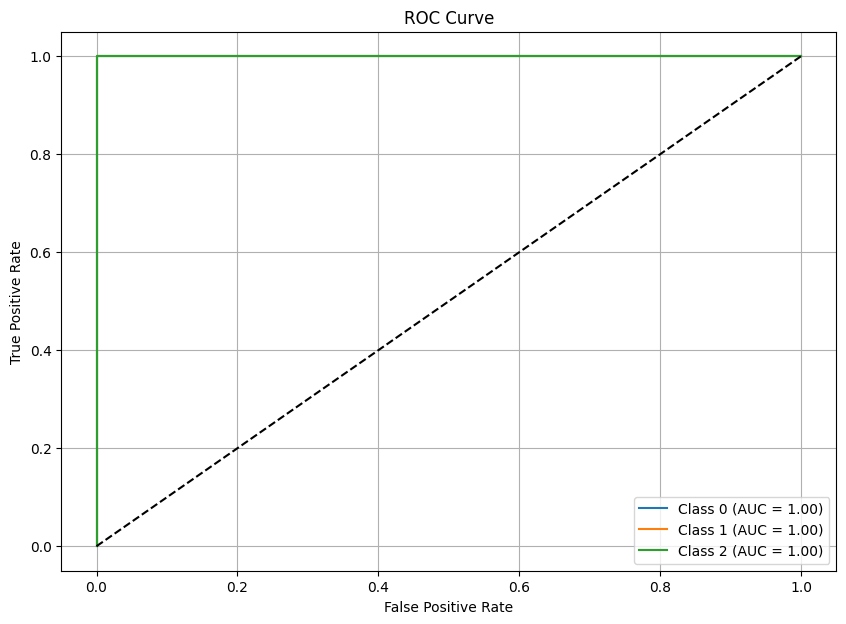

In [10]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Compute ROC Curve and AUC for each class
model.eval()
y_true = []
y_probs = []  # Store probabilities

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = nn.Softmax(dim=1)(outputs)  # Get probabilities
        y_probs.append(probabilities.cpu().numpy())
        y_true.append(labels.cpu().numpy())

# Convert lists to numpy arrays
y_true = np.concatenate(y_true)
y_probs = np.concatenate(y_probs)

# Plot ROC for each class
n_classes = y_probs.shape[1]
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true == i, y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()


In [11]:
from sklearn.metrics import classification_report

# Predict on the test set
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())

# Convert lists to numpy arrays
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# Generate classification report
report = classification_report(y_true, y_pred, target_names=["Abuse", "Arrest", "Normal"])
print(report)


              precision    recall  f1-score   support

       Abuse       1.00      0.99      1.00       285
      Arrest       0.99      1.00      0.99       198
      Normal       1.00      1.00      1.00       235

    accuracy                           1.00       718
   macro avg       1.00      1.00      1.00       718
weighted avg       1.00      1.00      1.00       718



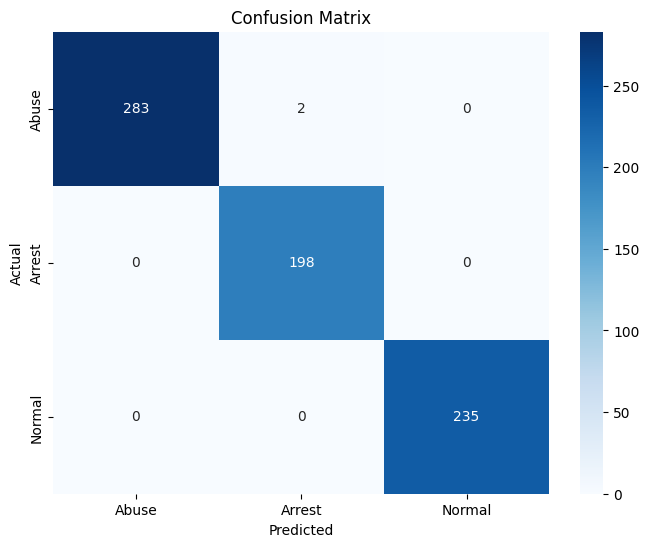

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=["Abuse", "Arrest", "Normal"], 
            yticklabels=["Abuse", "Arrest", "Normal"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [13]:
torch.save(model, "densenet121_5class.pth")

In [17]:
# Save the trained model

model_path = "C:\\Users\\Rohini\\capstone_Project\\prjct3\\densenet121_5class_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


Model saved to C:\Users\Rohini\capstone_Project\prjct3\densenet121_5class_model.pth


In [18]:
torch.save(model, "C:\\Users\\Rohini\\capstone_Project\\prjct3\\densenet121_5class_entire_model.pth")


Epoch 1/10, Train Loss: 0.0024, Train Accuracy: 99.95%, Val Loss: 0.0010, Val Accuracy: 100.00%
Epoch 2/10, Train Loss: 0.0025, Train Accuracy: 99.95%, Val Loss: 0.0002, Val Accuracy: 100.00%
Epoch 3/10, Train Loss: 0.0017, Train Accuracy: 99.95%, Val Loss: 0.0047, Val Accuracy: 99.86%
Epoch 4/10, Train Loss: 0.0162, Train Accuracy: 99.54%, Val Loss: 0.0031, Val Accuracy: 100.00%
Epoch 5/10, Train Loss: 0.0074, Train Accuracy: 99.81%, Val Loss: 0.0003, Val Accuracy: 100.00%
Epoch 6/10, Train Loss: 0.0028, Train Accuracy: 99.91%, Val Loss: 0.0002, Val Accuracy: 100.00%
Epoch 7/10, Train Loss: 0.0154, Train Accuracy: 99.91%, Val Loss: 0.0005, Val Accuracy: 100.00%
Epoch 8/10, Train Loss: 0.0150, Train Accuracy: 99.63%, Val Loss: 0.0040, Val Accuracy: 99.86%
Epoch 9/10, Train Loss: 0.0019, Train Accuracy: 99.95%, Val Loss: 0.0024, Val Accuracy: 99.86%
Epoch 10/10, Train Loss: 0.0017, Train Accuracy: 99.95%, Val Loss: 0.0041, Val Accuracy: 99.86%


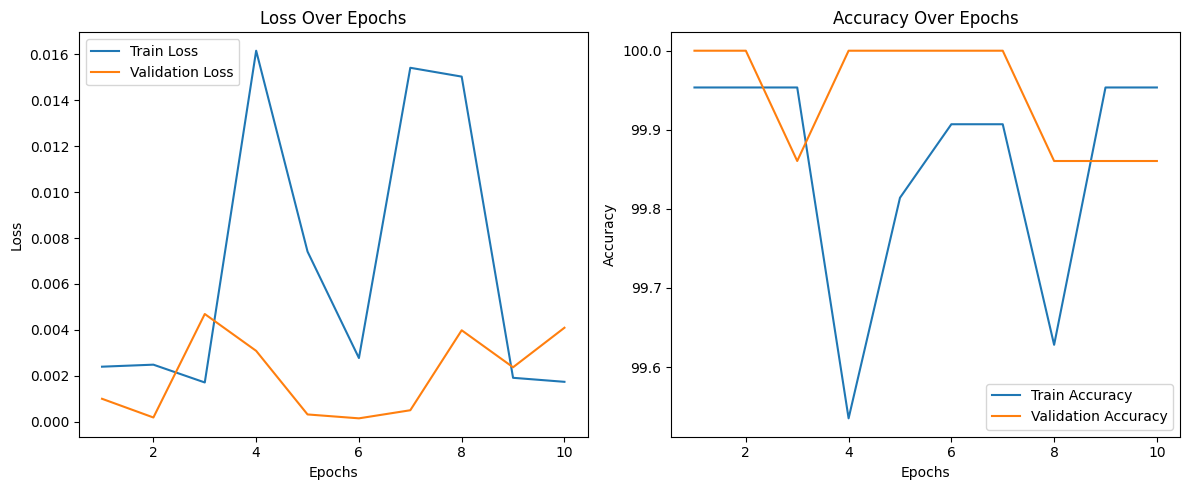

In [20]:
import matplotlib.pyplot as plt

# Initialize the history dictionary to store loss and accuracy for each epoch
history = {
    'train_loss': [],
    'val_loss': [],
    'train_accuracy': [],
    'val_accuracy': []
}

# Assuming the model, criterion, optimizer, and data loaders are already defined

epochs = 10  # Number of epochs
for epoch in range(epochs):
    # Training Phase
    model.train()  # Set the model to training mode
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        # Move data to the appropriate device
        images, labels = images.to(device), labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Compute the loss
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = 100 * correct_train / total_train
    history['train_loss'].append(train_loss / len(train_loader))  # Average train loss
    history['train_accuracy'].append(train_accuracy)  # Train accuracy

    # Validation Phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():  # Disable gradient computation for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Compute the loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_accuracy = 100 * correct_val / total_val
    history['val_loss'].append(val_loss / len(val_loader))  # Average validation loss
    history['val_accuracy'].append(val_accuracy)  # Validation accuracy
    
    # Print the metrics for this epoch
    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {val_accuracy:.2f}%")

# After training, plot the metrics
plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), history['train_loss'], label='Train Loss')
plt.plot(range(1, epochs+1), history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), history['train_accuracy'], label='Train Accuracy')
plt.plot(range(1, epochs+1), history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [21]:
torch.save(model, "densenet121_5class.pth")

In [22]:
# Save the trained model

model_path = "C:\\Users\\Rohini\\capstone_Project\\prjct3\\densenet121_5class_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


Model saved to C:\Users\Rohini\capstone_Project\prjct3\densenet121_5class_model.pth


In [23]:
torch.save(model, "C:\\Users\\Rohini\\capstone_Project\\prjct3\\densenet121_5class_entire_model.pth")


In [24]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 99.72%


In [25]:
# Save the trained model

model_path = "C:\\Users\\Rohini\\capstone_Project\\prjct3\\densenet121_5class_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


Model saved to C:\Users\Rohini\capstone_Project\prjct3\densenet121_5class_model.pth


In [26]:
torch.save(model, "C:\\Users\\Rohini\\capstone_Project\\prjct3\\densenet121_5class_entire_model.pth")


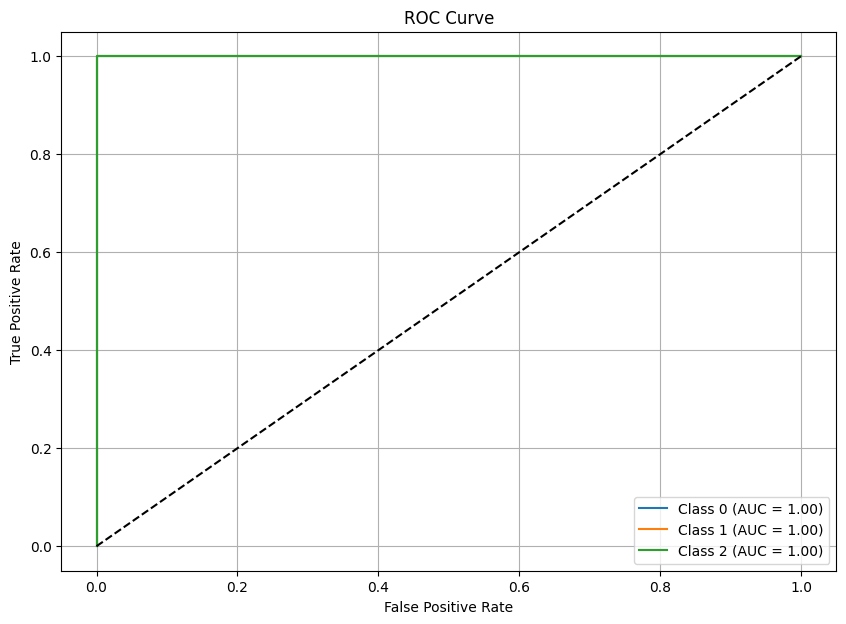

In [27]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Compute ROC Curve and AUC for each class
model.eval()
y_true = []
y_probs = []  # Store probabilities

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = nn.Softmax(dim=1)(outputs)  # Get probabilities
        y_probs.append(probabilities.cpu().numpy())
        y_true.append(labels.cpu().numpy())

# Convert lists to numpy arrays
y_true = np.concatenate(y_true)
y_probs = np.concatenate(y_probs)

# Plot ROC for each class
n_classes = y_probs.shape[1]
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true == i, y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()


In [28]:
from sklearn.metrics import classification_report

# Predict on the test set
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())

# Convert lists to numpy arrays
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# Generate classification report
report = classification_report(y_true, y_pred, target_names=["Abuse", "Arrest", "Normal"])
print(report)


              precision    recall  f1-score   support

       Abuse       1.00      0.99      1.00       285
      Arrest       0.99      1.00      0.99       198
      Normal       1.00      1.00      1.00       235

    accuracy                           1.00       718
   macro avg       1.00      1.00      1.00       718
weighted avg       1.00      1.00      1.00       718



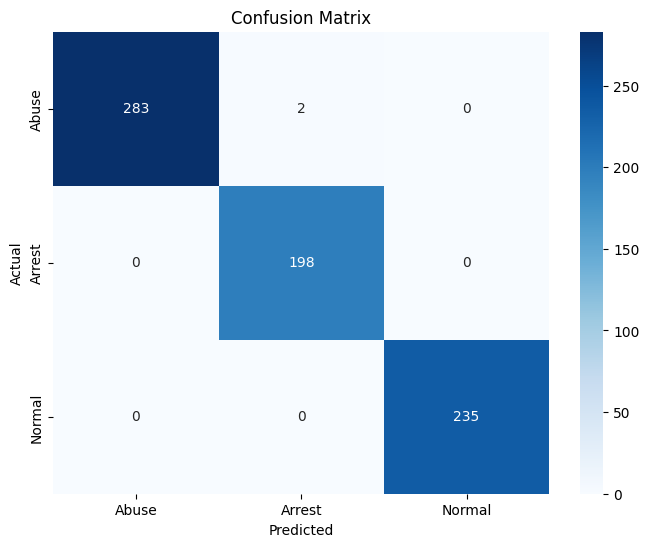

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=["Abuse", "Arrest", "Normal"], 
            yticklabels=["Abuse", "Arrest", "Normal"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


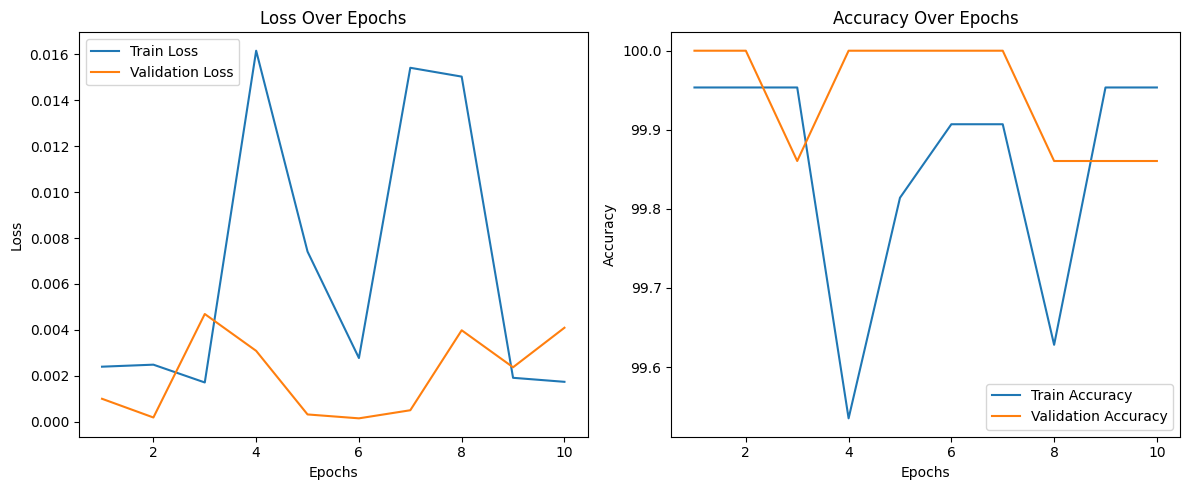

In [30]:
# Assuming 'history' dictionary from training phase
plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), history['train_loss'], label='Train Loss')
plt.plot(range(1, epochs+1), history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), history['train_accuracy'], label='Train Accuracy')
plt.plot(range(1, epochs+1), history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


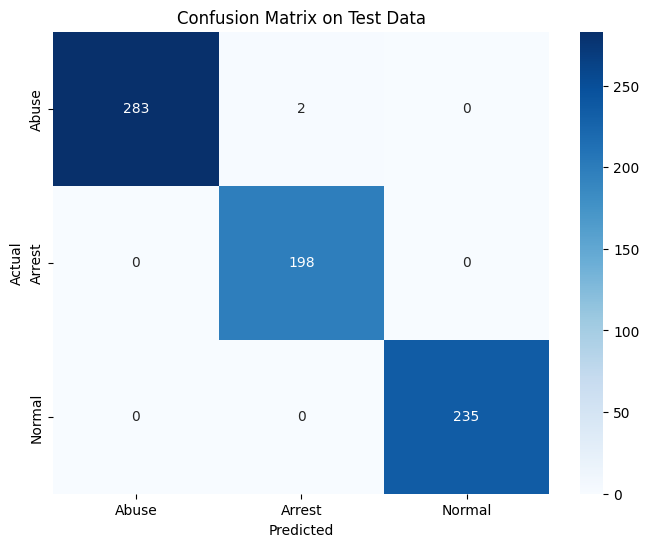

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

y_true = []
y_pred = []

# Assuming model and test_loader are already defined and model is in eval mode
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix with a custom title
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=["Abuse", "Arrest", "Normal"], 
            yticklabels=["Abuse", "Arrest", "Normal"])

# Add custom title
plt.title('Confusion Matrix on Test Data')  # Custom title
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()


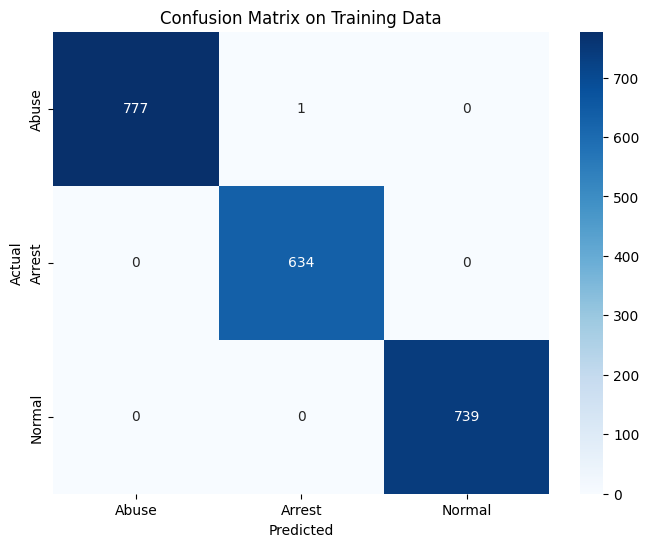

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = []
y_pred = []

# Assuming the model is already in eval mode and the train_loader is defined
model.eval()  # Set the model to evaluation mode (to disable dropout, batch norm, etc.)
with torch.no_grad():  # No need to track gradients for inference
    for images, labels in train_loader:  # Use train_loader instead of test_loader
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix with a custom title
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=["Abuse", "Arrest", "Normal"], 
            yticklabels=["Abuse", "Arrest", "Normal"])

# Add custom title for training data
plt.title('Confusion Matrix on Training Data')  # Custom title
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()


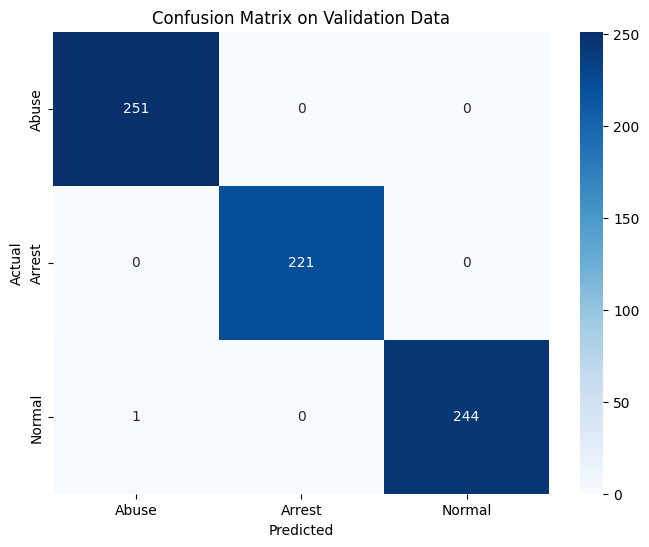

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = []
y_pred = []

# Assuming the model is already in eval mode and the val_loader is defined
model.eval()  # Set the model to evaluation mode (to disable dropout, batch norm, etc.)
with torch.no_grad():  # No need to track gradients for inference
    for images, labels in val_loader:  # Use val_loader for validation data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix with a custom title
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=["Abuse", "Arrest", "Normal"], 
            yticklabels=["Abuse", "Arrest", "Normal"])

# Add custom title for validation data
plt.title('Confusion Matrix on Validation Data')  # Custom title
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()


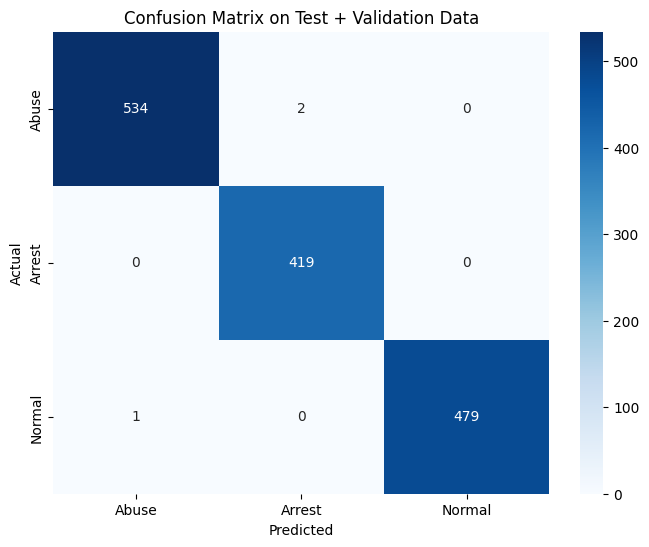

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = []
y_pred = []

# Model evaluation mode
model.eval()

# Collect predictions for both test and validation data
with torch.no_grad():
    # Iterate over test_loader
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
    
    # Iterate over val_loader
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix with a custom title
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=["Abuse", "Arrest", "Normal"], 
            yticklabels=["Abuse", "Arrest", "Normal"])

# Add custom title for test + validation data
plt.title('Confusion Matrix on Test + Validation Data')  # Custom title
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()


In [37]:
from sklearn.metrics import classification_report

# Generate the classification report
class_labels = ['Abuse', 'Arrest', 'Normal']
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)


              precision    recall  f1-score   support

       Abuse       1.00      1.00      1.00       536
      Arrest       1.00      1.00      1.00       419
      Normal       1.00      1.00      1.00       480

    accuracy                           1.00      1435
   macro avg       1.00      1.00      1.00      1435
weighted avg       1.00      1.00      1.00      1435



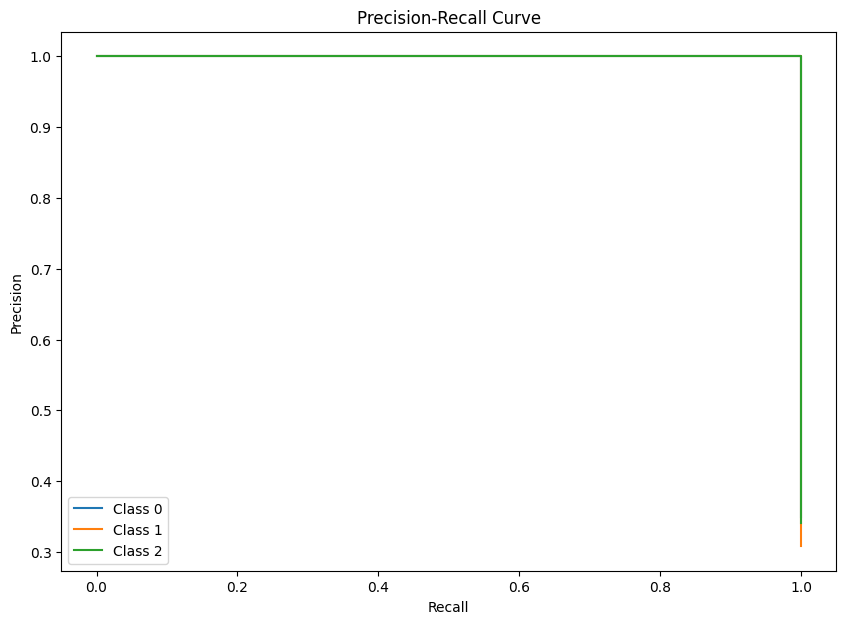

In [46]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image

# Assuming the dataset has been set up as shown earlier
# Define a simple function to flatten the images

def flatten_images(images):
    # Flatten each image (convert to 1D array)
    return images.view(images.size(0), -1).cpu().numpy()  # Flatten to (batch_size, num_pixels)

# Step 2: Load and flatten the images from train_loader
X_train = []
y_train = []

for images, labels in train_loader:
    images = images.to(device)  # Move images to device (GPU/CPU)
    images_flat = flatten_images(images)  # Flatten the images
    X_train.extend(images_flat)
    y_train.extend(labels.cpu().numpy())  # Collect labels

X_train = np.array(X_train)  # Convert to numpy array for training
y_train = np.array(y_train)

# Step 3: Train the RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)  # Train the model

# Step 4: Predict on the validation/test set (similarly flatten images)
X_val = []
y_val = []

for images, labels in val_loader:
    images = images.to(device)
    images_flat = flatten_images(images)
    X_val.extend(images_flat)
    y_val.extend(labels.cpu().numpy())

X_val = np.array(X_val)
y_val = np.array(y_val)

# Get predicted probabilities
y_pred_probs = model.predict_proba(X_val)

# Step 5: Precision-Recall Curve
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

y_true_onehot = label_binarize(y_val, classes=[0, 1, 2])  # One-hot encode the true labels

plt.figure(figsize=(10, 7))
for i in range(3):  # For each class (3 classes)
    precision, recall, _ = precision_recall_curve(y_true_onehot[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, label=f'Class {i}')

plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()
